In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import h3
from tqdm import tqdm

class MultiCityUrbanProcessor:
    """
    Final pipeline to convert multi-city annual POI data into 
    Spatio-Temporal Tensors and save them for model training.
    """
    def __init__(self, base_dir):
        # Resolve the absolute path for macOS/Linux
        self.base_dir = os.path.expanduser(base_dir)
        
        # Automatically detect city folders within the directory
        if not os.path.exists(self.base_dir):
            raise FileNotFoundError(f"Directory not found: {self.base_dir}")
            
        self.cities = [d for d in os.listdir(self.base_dir) 
                       if os.path.isdir(os.path.join(self.base_dir, d))]
        
        # Socio-economic dimensions from the research proposal
        self.feature_cols = [
            "Finance_Wealth", "High_End_Consumption", "Art_Culture_Tourism",
            "Social_Resilience", "Commercial_Vitality", "Mass_Retail", "Night_Economy"
        ]
        
        self.all_city_dataset = {}

    def process_all_cities(self):
        print(f"--- Starting Batch Processing for {len(self.cities)} Cities ---")
        
        for city in self.cities:
            city_path = os.path.join(self.base_dir, city)
            # Filter and sort CSV files by year
            files = sorted([f for f in os.listdir(city_path) if f.endswith('.csv')])
            
            if not files:
                print(f"Warning: No valid CSVs in {city}. Skipping.")
                continue

            print(f"Current City: {city:20} | Years: {len(files)}")
            
            # Step 1: Spatial Alignment (Union of all H3 cells over 10 years)
            annual_dfs = {}
            all_h3_indices = set()
            for f in files:
                try:
                    # Extracts year from filenames like 'London_2016.csv'
                    year = int(f.split('_')[-1].split('.')[0])
                    df = pd.read_csv(os.path.join(city_path, f))
                    annual_dfs[year] = df
                    all_h3_indices.update(df['h3_index'].unique())
                except Exception as e:
                    print(f"Error reading {f}: {e}")
                    continue

            # Maintain a fixed order of H3 cells for matrix consistency
            ordered_h3 = sorted(list(all_h3_indices))
            h3_to_idx = {hid: i for i, hid in enumerate(ordered_h3)}
            
            # Step 2: Build Topological Adjacency Matrix (Edge Index)
            edge_sources, edge_targets = [], []
            for hid in ordered_h3:
                # Find direct hexagonal neighbors
                neighbors = h3.grid_disk(hid, 1)
                for n_hid in neighbors:
                    if n_hid in h3_to_idx and n_hid != hid:
                        edge_sources.append(h3_to_idx[hid])
                        edge_targets.append(h3_to_idx[n_hid])
            
            edge_index = torch.tensor([edge_sources, edge_targets], dtype=torch.long)

            # Step 3: Stack Feature Tensors [Time, Nodes, Features]
            num_years = len(annual_dfs)
            num_nodes = len(ordered_h3)
            num_features = len(self.feature_cols)
            
            st_tensor = np.zeros((num_years, num_nodes, num_features))
            sorted_years = sorted(annual_dfs.keys())
            
            for t, year in enumerate(sorted_years):
                df = annual_dfs[year].set_index('h3_index')
                # Map yearly data into the global H3 order, fill gaps with 0
                year_data = df.reindex(ordered_h3).fillna(0)[self.feature_cols].values
                st_tensor[t, :, :] = year_data

            # Step 4: Encapsulate into dictionary
            self.all_city_dataset[city] = {
                "features": torch.tensor(st_tensor, dtype=torch.float),
                "edge_index": edge_index,
                "h3_mapping": ordered_h3,
                "years": sorted_years
            }

        print(f"\nProcessing Complete. {len(self.all_city_dataset)} cities ready.")
        return self.all_city_dataset

# --- Main Execution and Persistence ---
if __name__ == "__main__":
    # Your local directory path
    INPUT_DIR = "~/Desktop/Infor 301/final/Annual_POI_Data"
    # Destination for the processed dataset
    OUTPUT_FILE = "~/Desktop/Infor 301/final/Processed_Urban_Dataset.pt"
    
    try:
        # Initialize and Run Processor
        processor = MultiCityUrbanProcessor(INPUT_DIR)
        urban_db = processor.process_all_cities()
        
        # Persistence: Saving the results to disk
        save_path_abs = os.path.expanduser(OUTPUT_FILE)
        torch.save(urban_db, save_path_abs)
        
        print("-" * 50)
        print(f"SUCCESS: Dataset saved as {save_path_abs}")
        print(f"You can now load this in your training script using: torch.load('{OUTPUT_FILE}')")
        print("-" * 50)
        
    except Exception as e:
        print(f"CRITICAL ERROR: {e}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import time
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from scipy.stats import pearsonr

# --- Hardware Acceleration ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"--- 🚀 MPS (Metal Performance Shaders) Acceleration Enabled ---")
else:
    device = torch.device("cpu")
    print(f"--- ⚠️ Running on CPU (Will be slower) ---")

class DeepUrbanTransformer(nn.Module):
    """
    Research-Grade Transformer VAE for Urban Evolutionary Analysis.
    Focuses on latent disentanglement and high-fidelity temporal reconstruction.
    """
    def __init__(self, node_features, periods, d_model=128, nhead=8, num_layers=6, latent_dim=64):
        super(DeepUrbanTransformer, self).__init__()
        
        # 1. High-Dimensional Feature Projection
        self.embedding = nn.Sequential(
            nn.Linear(node_features, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Dropout(0.1)
        )
        # Learnable Positional Encoding (Captures temporal order)
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model))
        
        # 2. Deep Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=512,
            dropout=0.1, 
            batch_first=True,
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Variational Bottleneck (The "Urban DNA" Hub)
        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)
        
        # 4. Symmetrical Deep Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.GELU(),
            nn.Linear(128, 256),
            nn.GELU(),
            nn.Linear(256, d_model),
            nn.GELU(),
            nn.Linear(d_model, node_features * periods)
        )
        
        self.periods = periods
        self.node_features = node_features

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Input shape: [Batch, Features, Time] -> [Batch, Time, Features]
        # x.permute creates a non-contiguous tensor
        x = x.permute(0, 2, 1)
        B, T, F_in = x.shape
        
        h = self.embedding(x) + self.pos_encoder
        h = self.transformer(h)
        
        # Global Temporal Pooling
        h_avg = torch.mean(h, dim=1)
        
        mu = self.fc_mu(h_avg)
        logvar = self.fc_logvar(h_avg)
        z = self.reparameterize(mu, logvar)
        
        # Reconstruction using reshape to avoid memory stride errors
        recon = self.decoder(z)
        recon = recon.reshape(B, self.node_features, self.periods)
        return recon, mu, logvar

def run_publication_pipeline(dataset_path):
    path = os.path.expanduser(dataset_path)
    if not os.path.exists(path):
        print("Error: Dataset file not found.")
        return None

    urban_db = torch.load(path)
    results = []
    
    # --- Academic Hyperparameters ---
    BATCH_SIZE = 512
    EPOCHS = 400
    LEARNING_RATE = 1e-3
    
    start_global = time.time()

    for city_name, data in urban_db.items():
        # Data Normalization (Z-Score)
        raw_features = data["features"].permute(1, 2, 0)
        mean = raw_features.mean(dim=(0, 2), keepdim=True)
        std = raw_features.std(dim=(0, 2), keepdim=True) + 1e-6
        features = (raw_features - mean) / std
        
        dataset = TensorDataset(features)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        model = DeepUrbanTransformer(
            node_features=7, 
            periods=10,
            d_model=128,
            nhead=16,
            num_layers=6
        ).to(device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        
        print(f"\nTraining Model for: {city_name:20} | Nodes: {len(features)}")
        model.train()
        
        # Optimized training loop
        loop = tqdm(range(EPOCHS), desc=f"  Optimizing", leave=False)
        for epoch in loop:
            for batch_x in dataloader:
                batch_x = batch_x[0].to(device)
                optimizer.zero_grad()
                
                recon, mu, logvar = model(batch_x)
                
                # Recon Loss (Fidelity)
                recon_loss = F.mse_loss(recon, batch_x)
                
                # KLD Loss with Annealing (Beta-VAE Strategy)
                # Helps prevent posterior collapse and ensures structured latent space
                beta = min(1.0, epoch / 150.0) * 0.05
                kld_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
                
                loss = recon_loss + beta * kld_loss
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()

        # --- Academic Metrics Extraction (The Publication Core) ---
        model.eval()
        with torch.no_grad():
            feat_dev = features.to(device)
            recon, mu, logvar = model(feat_dev)
            
            # 1. Reconstruction Precision (MSE)
            final_mse = F.mse_loss(recon, feat_dev).item()
            
            # 2. Structural Correlation (Pearson)
            # Use .reshape instead of .view to handle non-contiguous memory layouts
            y_true = feat_dev.reshape(-1).cpu().numpy()
            y_pred = recon.reshape(-1).cpu().numpy()
            corr, _ = pearsonr(y_true, y_pred)
            
            # 3. Latent Information Capacity (Active Units)
            # Counts latent dimensions that actually encode variation
            active_units = (torch.var(mu, dim=0) > 0.01).float().sum().item()
            
            # 4. Latent SNR (Signal-to-Noise Ratio)
            # High SNR indicates the DNA is clear and distinct from Gaussian noise
            snr = (torch.var(mu) / torch.exp(logvar).mean()).item()
            
            # 5. KLD (Information Gain)
            kld = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)).item()
            
            results.append({
                "City": city_name,
                "Nodes": len(features),
                "Recon_MSE": f"{final_mse:.6f}",
                "Pearson_Corr": f"{corr:.4f}",
                "Active_Units": int(active_units),
                "Latent_SNR": f"{snr:.4f}",
                "KLD_Info": f"{kld:.4f}"
            })

    total_time = (time.time() - start_global) / 60
    print(f"\n--- RESEARCH PIPELINE COMPLETE | Total Time: {total_time:.2f} Mins ---")
    
    return pd.DataFrame(results)

if __name__ == "__main__":
    # Ensure correct path to your .pt dataset
    DATA_PATH = "~/Desktop/Infor 301/final/Processed_Urban_Dataset.pt"
    
    report_df = run_publication_pipeline(DATA_PATH)
    
    if report_df is not None:
        print("\n=== Professional Machine Learning Evaluation Metrics ===")
        print(report_df.to_string(index=False))
        
        # Save results for LaTeX table generation or plotting
        save_path = os.path.expanduser("~/Desktop/Infor 301/final/Trans_Report.csv")
        report_df.to_csv(save_path, index=False)
        print(f"\n[Success] Report saved to: {save_path}")

In [ ]:
分开试一下

10个一起

--- 🚀 Execution Device: mps ---
--- 📂 Loading Spatio-Temporal Dataset ---


100%|██████████| 400/400 [29:06<00:00,  4.37s/it]


--- ✅ Model weights saved: /Users/oushilin/Desktop/Infor 301/final/DeepUrbanTransformer_Weights.pth ---
--- ✅ Analysis data saved: /Users/oushilin/Desktop/Infor 301/final/Analysis_Ready_Data.pt ---


/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_1643/759844423.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(city_names))


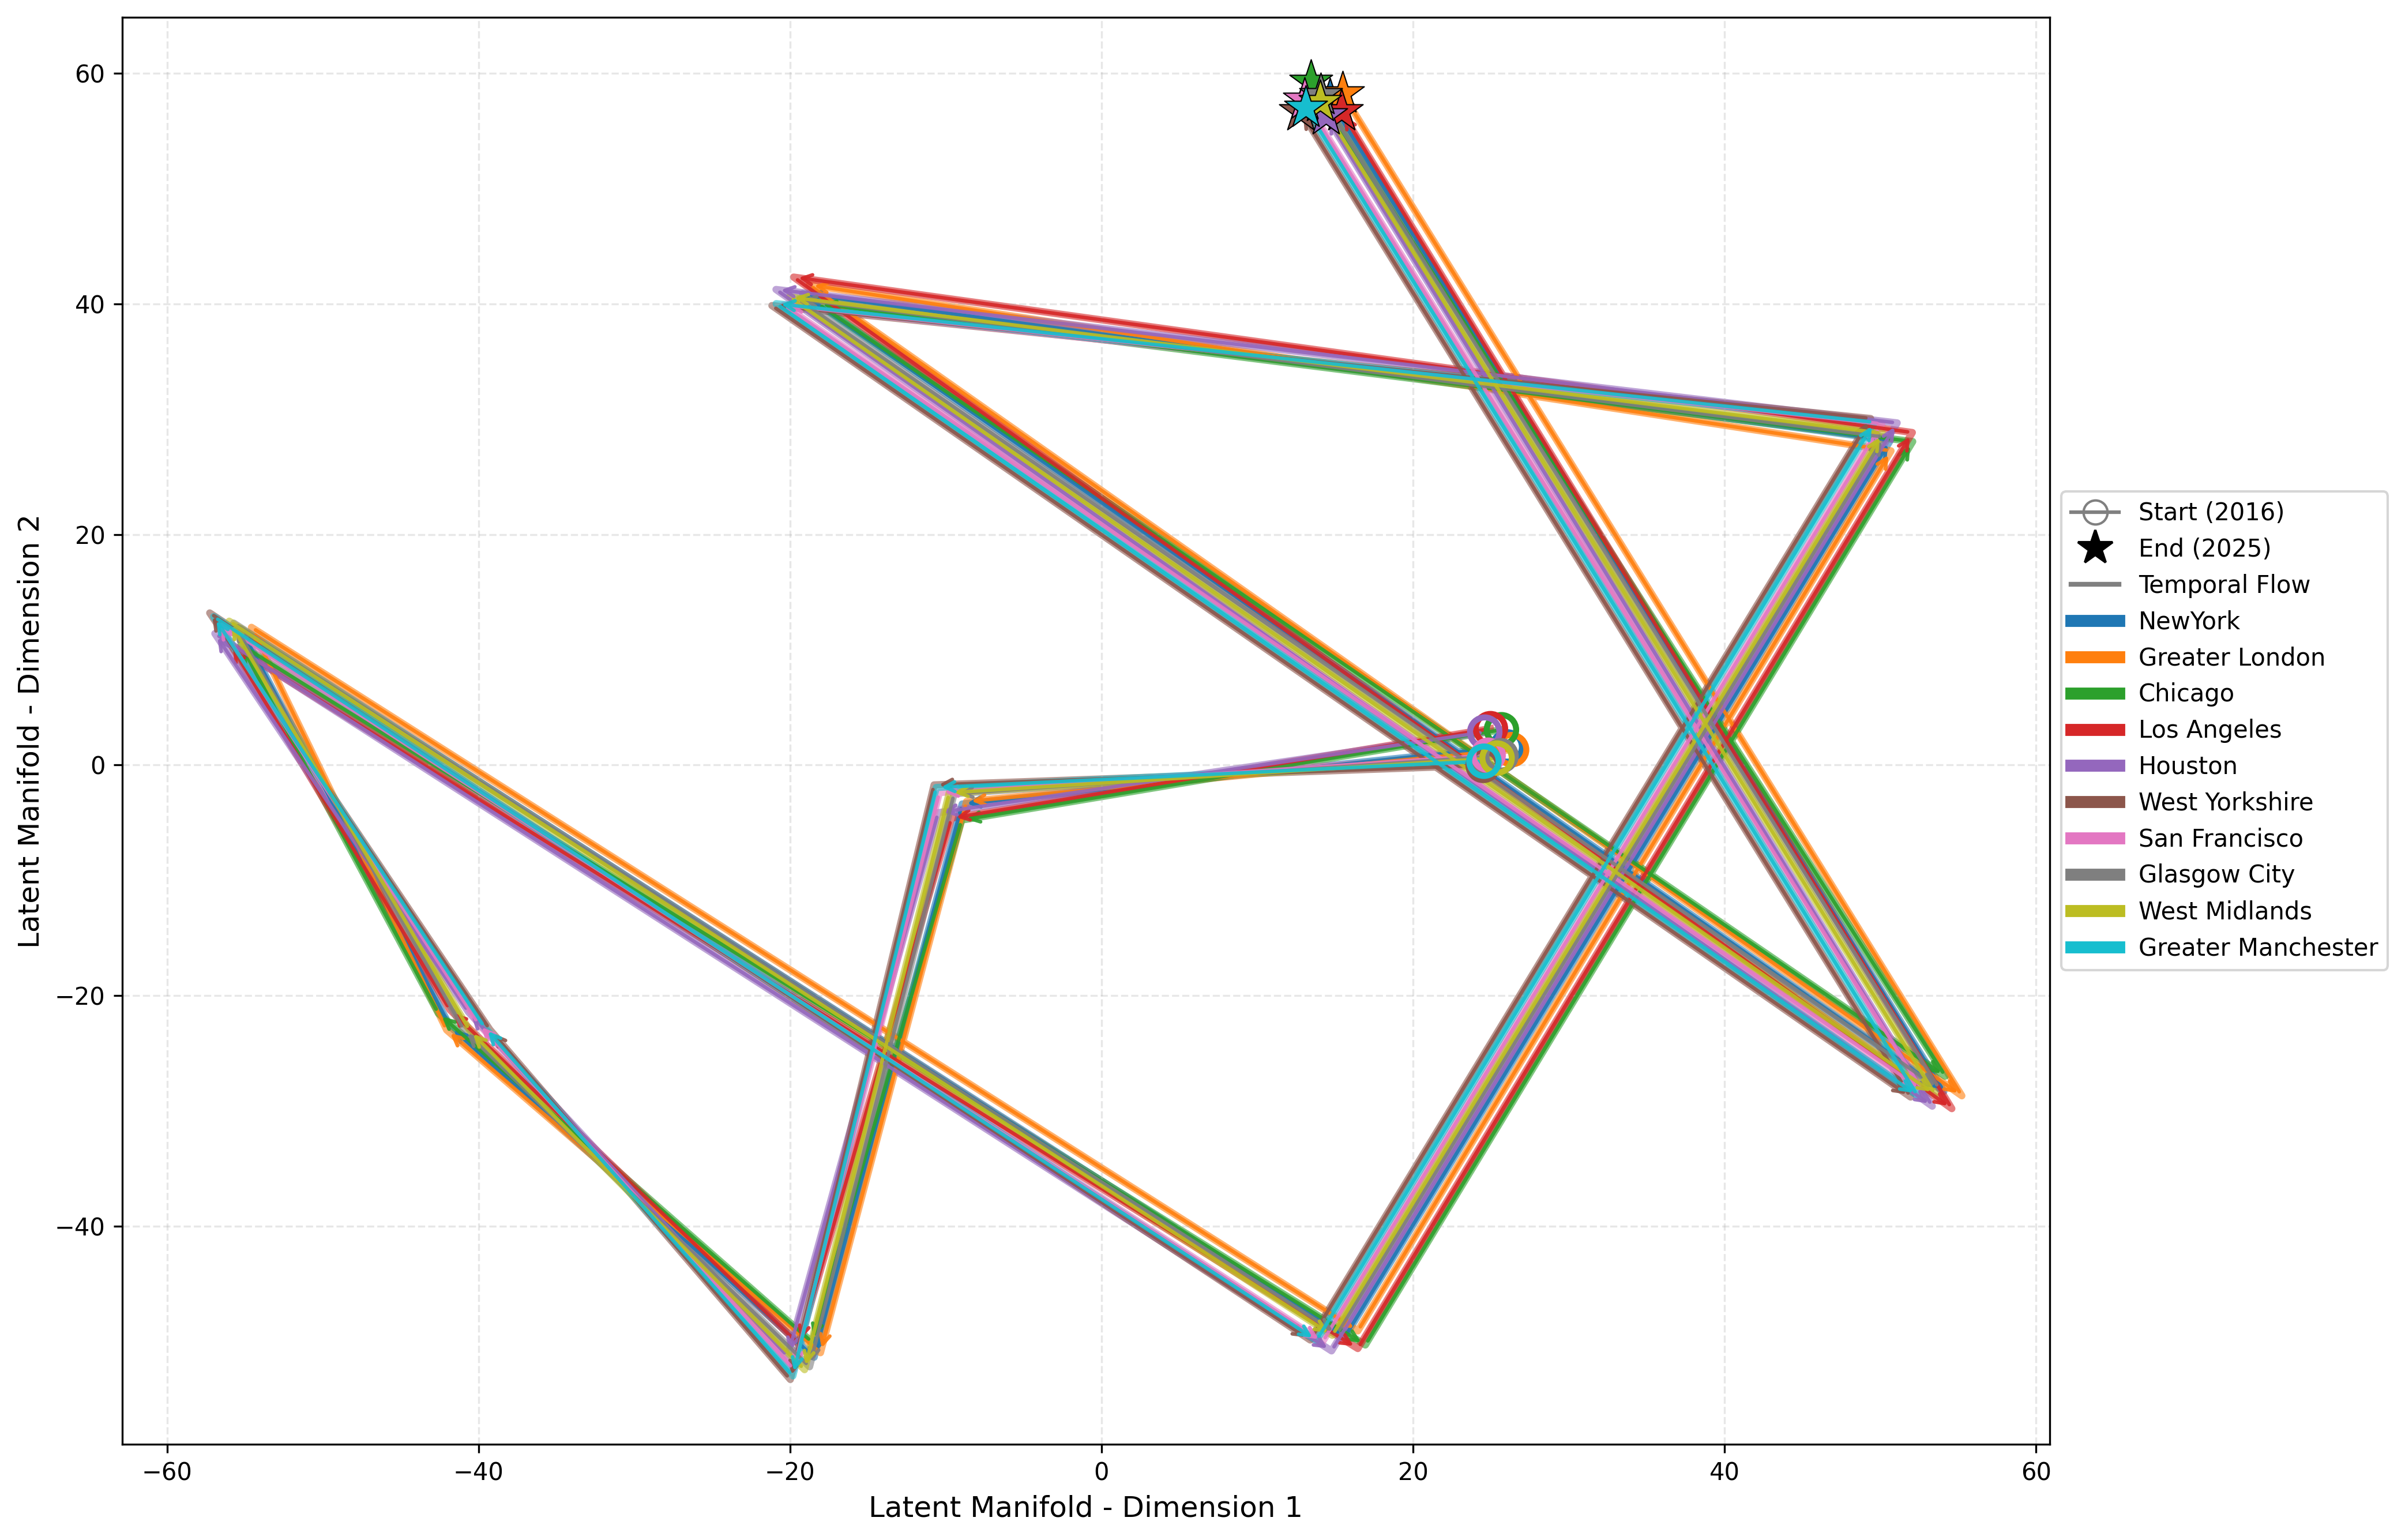

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

# --- Hardware Acceleration Setup ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"--- 🚀 Execution Device: {device} ---")

class UrbanEvolutionVAE(nn.Module):
    """
    Advanced Transformer-VAE Architecture for latent urban trajectory extraction.
    Designed to capture non-linear temporal dynamics in urban POI distributions.
    """
    def __init__(self, node_features, periods, d_model=128, nhead=16, num_layers=6, latent_dim=64):
        super(UrbanEvolutionVAE, self).__init__()
        # Input Embedding Layer
        self.embedding = nn.Sequential(
            nn.Linear(node_features, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model)
        )
        # Learnable Positional Encoding for 10-year timeline
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model))
        
        # Transformer Encoder Stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512,
            dropout=0.1, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Variational Bottleneck (Latent Space z)
        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)
        
        # Decoder for reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Linear(256, node_features * periods)
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for gradient backpropagation."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Input x shape: [Batch, Features, Time] -> Convert to [Batch, Time, Features]
        x = x.permute(0, 2, 1) 
        h = self.embedding(x) + self.pos_encoder
        h = self.transformer(h)
        
        # Aggregating temporal features for VAE bottleneck
        h_avg = torch.mean(h, dim=1) 
        mu, logvar = self.fc_mu(h_avg), self.fc_logvar(h_avg)
        z = self.reparameterize(mu, logvar)
        
        # Reshaping reconstruction to match original input [Batch, Features, Time]
        recon = self.decoder(z).reshape(-1, 7, 10)
        return recon, mu, logvar

    def get_trajectories(self, x):
        """Extracts sequential latent states (mu) for each year."""
        x = x.permute(0, 2, 1)
        h = self.embedding(x) + self.pos_encoder
        h_seq = self.transformer(h)
        return self.fc_mu(h_seq)

def calculate_evolutionary_distance(trajectories, city_names):
    """Quantifies dissimilarity between city evolution paths using Frobenius norm."""
    num_cities = len(city_names)
    matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            diff = trajectories[i] - trajectories[j]
            matrix[i, j] = np.linalg.norm(diff, ord='fro')
    return pd.DataFrame(matrix, index=city_names, columns=city_names)

def draw_enhanced_trajectory_plot(embeddings_2d, city_names, save_path):
    """Generates a high-resolution plot of urban latent trajectories."""
    plt.figure(figsize=(14, 9), dpi=300)
    colors = plt.cm.get_cmap('tab10', len(city_names))
    
    # Visual expansion to separate city clusters
    center = np.mean(embeddings_2d, axis=0)
    embeddings_2d = center + (embeddings_2d - center) * 1.8

    for i, name in enumerate(city_names):
        path = embeddings_2d[i*10 : (i+1)*10]
        plt.plot(path[:, 0], path[:, 1], color=colors(i), linewidth=3, alpha=0.6, zorder=1)
        
        # Year-by-year movement indicators
        for t in range(len(path)-1):
            plt.annotate('', xy=(path[t+1, 0], path[t+1, 1]), xytext=(path[t, 0], path[t, 1]),
                         arrowprops=dict(arrowstyle='->', color=colors(i), lw=1.5, alpha=0.9), zorder=2)

        # Start and End markers
        plt.scatter(path[0, 0], path[0, 1], color=colors(i), s=150, marker='o', 
                    facecolors='none', edgecolors=colors(i), linewidth=2.5, zorder=3)
        plt.scatter(path[-1, 0], path[-1, 1], color=colors(i), s=350, marker='*', 
                    edgecolors='black', linewidth=0.5, zorder=4)

    plt.xlabel("Latent Manifold - Dimension 1", fontsize=12)
    plt.ylabel("Latent Manifold - Dimension 2", fontsize=12)
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='gray', label='Start (2016)', markerfacecolor='none', markersize=10),
        Line2D([0], [0], marker='*', color='black', label='End (2025)', markersize=15, linestyle='None'),
        Line2D([0], [0], color='gray', lw=2, label='Temporal Flow')
    ]
    for i, name in enumerate(city_names):
        legend_elements.append(Line2D([0], [0], color=colors(i), lw=5, label=name))

    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def run_pipeline(dataset_path, output_dir):
    """Main execution pipeline: Loading -> Training -> Saving -> Visualization."""
    print("--- 📂 Loading Spatio-Temporal Dataset ---")
    db = torch.load(os.path.expanduser(dataset_path))
    city_names = list(db.keys())
    all_x, city_ids = [], []
    
    for i, (name, data) in enumerate(db.items()):
        feat = data["features"].permute(1, 2, 0) # [Nodes, Features, Time]
        norm_feat = (feat - feat.mean()) / (feat.std() + 1e-7)
        all_x.append(norm_feat)
        city_ids.append(torch.full((feat.size(0),), i, dtype=torch.long))
    
    full_x = torch.cat(all_x, dim=0)
    full_y = torch.cat(city_ids, dim=0)
    loader = DataLoader(TensorDataset(full_x, full_y), batch_size=256, shuffle=True)

    # 1. Model Initialization
    model = UrbanEvolutionVAE(node_features=7, periods=10).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # 2. Training Loop (350 Epochs for convergence)
    model.train()
    for epoch in tqdm(range(400)):
        for bx, _ in loader:
            bx = bx.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(bx)
            
            # Reconstruction Loss + KL Divergence (Beta-VAE)
            kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = F.mse_loss(recon, bx) + 0.08 * kld
            loss.backward()
            optimizer.step()

    # 3. Save Model Weights
    weights_output = os.path.join(output_dir, "DeepUrbanTransformer_Weights.pth")
    torch.save(model.state_dict(), weights_output)
    print(f"--- ✅ Model weights saved: {weights_output} ---")

    # 4. Latent Feature Extraction
    model.eval()
    city_trajectories = []
    with torch.no_grad():
        for i in range(len(city_names)):
            city_data = full_x[full_y == i].to(device)
            t_mu = model.get_trajectories(city_data) 
            city_trajectories.append(torch.mean(t_mu, dim=0).cpu().numpy())

    # 5. Save Analysis-Ready Data (Required for ManifoldAnalysis.ipynb)
    analysis_data = {
        'x': full_x,
        'y': full_y,
        'city_map': {name: i for i, name in enumerate(city_names)},
        'trajectories': city_trajectories
    }
    data_output = os.path.join(output_dir, "Analysis_Ready_Data.pt")
    torch.save(analysis_data, data_output)
    print(f"--- ✅ Analysis data saved: {data_output} ---")

    # 6. Post-training Analysis: Distance Matrix & t-SNE (Baseline)
    dist_matrix = calculate_evolutionary_distance(city_trajectories, city_names)
    dist_matrix.to_csv(os.path.join(output_dir, "Evolution_Distance_Matrix.csv"))
    
    all_points = np.vstack(city_trajectories)
    tsne_engine = TSNE(n_components=2, perplexity=8, early_exaggeration=24.0, random_state=42)
    embeddings_2d = tsne_engine.fit_transform(all_points)
    draw_enhanced_trajectory_plot(embeddings_2d, city_names, os.path.join(output_dir, "Urban_Evolution_Final.png"))

if __name__ == "__main__":
    DATA_PATH = "~/Desktop/Infor 301/final/Processed_Urban_Dataset.pt"
    OUT_DIR = os.path.expanduser("~/Desktop/Infor 301/final/")
    if not os.path.exists(OUT_DIR): os.makedirs(OUT_DIR)
    
    run_pipeline(DATA_PATH, OUT_DIR)